In [1]:
import math
import numpy as np
import pandas as pd
import time
import copy
import matplotlib.pyplot as plt
import os

# import json
# import glob
from PIL import Image
# from tqdm import tqdm

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Images Into a Dataset

In [2]:
def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((30, 32)),
        transforms.RandomAffine(0, (0.1, 0.1)),
        transforms.ColorJitter(0.1, 0.1, 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((30, 32)),
        transforms.ToTensor()
    ])
}

data_dir = 'dataset'
image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [11]:
print(class_names)

['blue', 'garbage', 'green', 'purple', 'red', 'yellow']


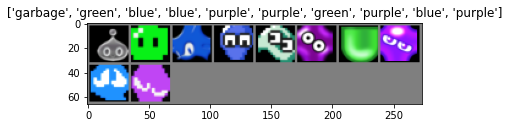

In [4]:
def imshow(inp: torch.Tensor, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Neural Network Model

In [5]:
class PuyoClassifier(nn.Module):
    def __init__(self):
        super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3), # -> [-1, 16, 28, 30]
#             nn.ReLU(),
#             nn.AvgPool2d(2, 2) # -> [-1, 16, 28, 30]
#         )

#         self.conv2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=3), # -> [-1, 32, 24, 26]
#             nn.ReLU(),
#         )
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), # -> [-1, 16, 28, 30]
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # -> [-1, 16, 14, 15]
            nn.Conv2d(16, 32, kernel_size=3), # -> [-1, 16, 12, 13]
            nn.ReLU(),
            nn.Conv2d(32, 10, kernel_size=3), # -> [-1, 10, 10, 11]
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(10 * 10 * 11, 100),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(100, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 6),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 10 * 10 * 11)
        x = self.fc(x)
        return x

## Training Parameters

## Model Training

In [6]:
lr = 0.0001
model = PuyoClassifier()
model.cuda(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train_model(model: nn.Module, criterion: nn.CrossEntropyLoss, optimizer: optim.Optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Track loss and accuracy over epochs
    hist = pd.DataFrame(columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        hist_row = [epoch]
    
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Run on CUDA
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize only if in training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            hist_row.append(epoch_loss)
            hist_row.append(epoch_acc.item())
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        hist.loc[epoch] = hist_row
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, hist

In [7]:
trained_model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, 10)

Epoch 0/9
----------
train Loss: 1.3492 Acc: 0.4766
val Loss: 1.0083 Acc: 0.6188

Epoch 1/9
----------
train Loss: 0.4239 Acc: 0.8788
val Loss: 0.4521 Acc: 0.8737

Epoch 2/9
----------
train Loss: 0.2422 Acc: 0.9463
val Loss: 0.3546 Acc: 0.9263

Epoch 3/9
----------
train Loss: 0.2144 Acc: 0.9573
val Loss: 0.3559 Acc: 0.9192

Epoch 4/9
----------
train Loss: 0.2098 Acc: 0.9562
val Loss: 0.3466 Acc: 0.9192

Epoch 5/9
----------
train Loss: 0.2051 Acc: 0.9566
val Loss: 0.3445 Acc: 0.9192

Epoch 6/9
----------
train Loss: 0.2006 Acc: 0.9586
val Loss: 0.3461 Acc: 0.9192

Epoch 7/9
----------
train Loss: 0.2055 Acc: 0.9566
val Loss: 0.3435 Acc: 0.9192

Epoch 8/9
----------
train Loss: 0.2009 Acc: 0.9571
val Loss: 0.3410 Acc: 0.9192

Epoch 9/9
----------
train Loss: 0.1988 Acc: 0.9571
val Loss: 0.3412 Acc: 0.9192

Training complete in 2m 47s
Best val Acc: 0.926275


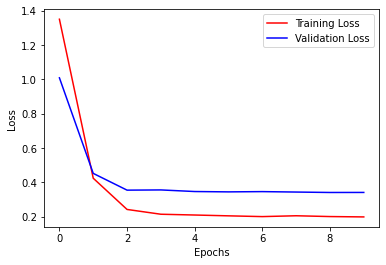

In [8]:
plt.plot(history.loc[:, 'epoch'], history.loc[:, 'train_loss'], 'r', label='Training Loss')
plt.plot(history.loc[:, 'epoch'], history.loc[:, 'val_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

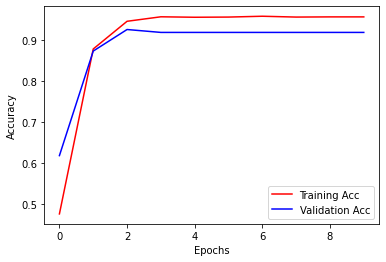

In [9]:
plt.plot(history.loc[:, 'epoch'], history.loc[:, 'train_acc'], 'r', label='Training Acc')
plt.plot(history.loc[:, 'epoch'], history.loc[:, 'val_acc'], 'b', label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
torch.save(model.state_dict(), 'puyo-classifier.pt')